<center>
    COMP4600/5300 - Reinforcement Learning

# Final Project

### Due: Thursday, Dec 9th 11:59 pm
    
</center>

Student Name: Mohamed Martini

In [1]:
from trainer import train
from learner import QAgent
from env_small import EnvSmall
from env_large import Env
import numpy as np
import matplotlib.pyplot as plt

pygame 2.0.1 (SDL 2.0.14, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Overview

### Small Env

For this part a discrete 2D ($N \times M$) environment was built, with dimensions $ N = M = 20 $. In this environment, the terminal state is surrounded by file, and the agent cannot reach it until it presses the button to kill the fire.

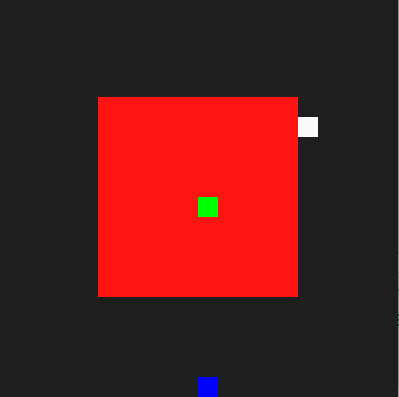
<h5 align="center">
    Figure 1 - Before pressing the button (blue), the terminal state (green) is surrounded by file and the agent (white) cannot get to it.
</h5>

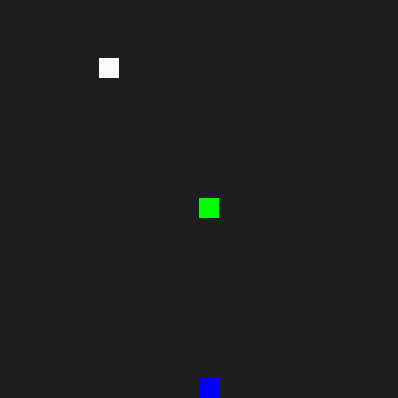
<h5 align="center">
    Figure 2 - After pressing the button (blue), the fire dies out and the agent can get to the terminal state (green).
</h5>

The challenge in this environment is that it changes when the button is pressed. Certain cells which could not be visited before become available when the button is pressed. This makes the problem effectively two problems in one: in the first part, the agent must press the button (visit the blue cell), then pursue the terminal state in the second part.

The state vector $\textbf{s}$ is composed of three elements: the row and column of the agent, and whether the button is pressed. 

$$
\textbf{s}_t = (row_{a_t} \in \mathcal{R}^N , col_{a_t} \in \mathcal{R}^M, btn_t \in [0, 1]); \in \mathcal{R}^{20 \times 20 \times 2}
$$

The agent can move in any of the four directions: 

$$
A = \{\rightarrow, \uparrow, \downarrow, \leftarrow\}
$$

At first, the agent was rewarded -1 at each time step, +1 for pressing the button and +1 for reaching the terminal state. While this should work theoretically, but in practice action values would take a very long time to propagate, because of the high number of timesteps in each episode and the small reward values. To fix this, the following reward profile was tried:

$$
R = 
\begin{cases}
    -10 & \text{each time step} \\
    -100 & \text{touching fire} \\
    +100 & \text{pressing button} \\
    +200 & \text{terminal state}
\end{cases}
$$

### Large Env

This environment is a scaled up version of the small environment, with a main difference, which is the moving hazard. In this environment, the agent must go a long way to discover that it first needs to press the blue button, then head to the terminal state at the other end of the map, where it is faced with a moving hazard, which is the red bar shown in Fig. 3 below. If the agent spawns in the bottom half of the map, it cannot reach the terminal state unless it presses the button (similar to the small env). When the button is pressed, the fire barrier is removed, and all other fire cells become walls. 

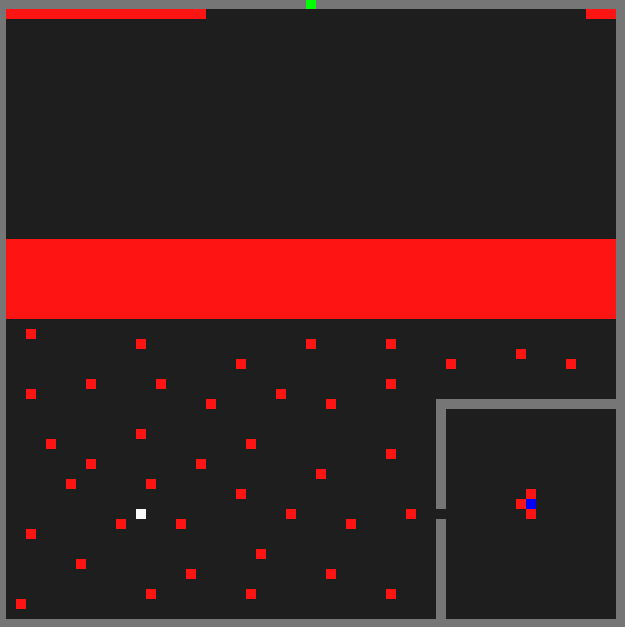
<h5 align="center">
    Figure 3 - After pressing the button (blue), the fire dies out and the agent can get to the terminal state (green).
</h5>
![image-2.png](attachment:image-2.png)
<h5 align="center">
    Figure 2 - After pressing the button (blue), the fire dies out and the agent can get to the terminal state (green).
</h5>

The state vector $\textbf{s}$ is composed of three elements: the row and column of the agent, and whether the button is pressed. 

$$
\textbf{s}_t = (row_{a_t} \in \mathcal{R}^N , col_{a_t} \in \mathcal{R}^M, col_{f_t} \in \mathcal{R}^M, btn_t \in [0, 1]); \in \mathcal{R}^{63 \times 63 \times 63 \times 2}
$$

The bar moves in a predicted manner, thus if we make the position of the bar to be in the state vector, then the agent can find the best actions to do when it is near the moving hazard. The added state dimension and the scaling up of the grid size makes the state space vastly larger, and the algorithm is predicted to take a long time to learn the optimal policy. The large state space as well means that small reward values will not propagate effectively. Thus, I used very large rewards, just to ensure that all the training time is not wasted. Also, I do not think that high rewards have negative impact on training, unless it is beyond the computer's capability.
The rewards are as follows:

$$
R = 
\begin{cases}
    -1000 & \text{each time step} \\
    -10,000 & \text{touching fire} \\
    500K & \text{pressing button} \\
    1M & \text{terminal state}
\end{cases}
$$

## Task 1

The Q learning algorithm was used due to its light weightedness and its adequacy to learn the given task. Use of a dynamic $\varepsilon$-greedy policy, and dynamic learning rate helped reduce the number of tunable parameters, making experimentation less time costly. $\varepsilon(s)$ and $\alpha(s,a)$ are given by:

$$\varepsilon(s) = \frac{1}{\sqrt{n(s)}}$$
$$\alpha(s,a)=\frac{1}{n(s,a)}$$

Another algorithm that could perform better at the cost of computation time is n-step SARSA, as it would help propagate the reward quickly.
Double Q learning was avoided beacuse it would increase computation time at no forsean benefit, as both environments are not stochastic. 

### Small Env

In [ ]:
actions = np.array([[0, 1], [-1, 0], [0, -1], [1, 0]])
n_actions = 4
n_dims_s = (n_actions, 20, 20, 2)
n_states_s = 3
n_episodes = 10_000
n_runs = 50

best_Q_s = None
best_reward = - np.inf
steps_per_e_per_r = np.zeros((n_runs, n_episodes))
r_per_e_per_r = np.zeros((n_runs, n_episodes))
for run in range(n_runs):
    env = EnvSmall(n_dims_s, n_states_s, actions)
    agent = QAgent(4, n_dims_s)
    Q, _, _, steps_per_e, r_per_e = train(n_episodes, env, agent, vis=False)
    steps_per_e_per_r[run] = steps_per_e
    r_per_e_per_r[run] = r_per_e
    if r_per_e.mean() > best_reward:
        best_reward = r_per_e.mean()
        best_Q_s = Q
        np.save("BEST_WEIGHTS_S", Q)

 98%|█████████▊| 9841/10000 [00:45<00:00, 294.37it/s]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle(f"Q Learning Performance in Small Env", fontsize=24)
titles = [f"Average Number of Time Steps Per Episode - {n_episodes} episodes over {n_runs} Runs", 
          f"Average Reward Per Episode - {n_episodes} episodes over {n_runs} Runs"]
xlabels = "Episode Number"
ylabels = ["Average Number of Time Steps", "Average Reward"]
plots = [steps_per_e_per_r, r_per_e_per_r]

for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=20)
    ax.set_xlabel(xlabels, fontsize=18)
    ax.set_ylabel(ylabels[i], fontsize=18)
    ax.plot(plots[i].mean(0))
    ax.grid()

plt.tight_layout()
plt.show()

### Large Env

In [ ]:
n_dims_l = (n_actions, 63, 63, 63, 2)
n_states_l = 4
n_episodes = 10_000
n_runs = 50

best_Q = None
best_reward = - np.inf
steps_per_e_per_r = np.zeros((n_runs, n_episodes))
r_per_e_per_r = np.zeros((n_runs, n_episodes))
for run in range(n_runs):
    env = Env(n_dims_l, n_states_l, actions)
    agent = QAgent(4, n_dims_l)
    Q, _, _, steps_per_e, r_per_e = train(n_episodes, env, agent, vis=False)
    steps_per_e_per_r[run] = steps_per_e
    r_per_e_per_r[run] = r_per_e
    if r_per_e.mean() > best_reward:
        best_reward = r_per_e.mean()
        best_Q = Q

        np.save("BEST_WEIGHTS_L", Q)
np.save("STEPS_PER_E_PER_R", steps_per_e_per_r)
np.save("R_PER_E_PER_R", r_per_e_per_r)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle(f"Q Learning Performance in Large Env", fontsize=24)
titles = [f"Average Number of Time Steps Per Episode - {n_episodes} episodes over {n_runs} Runs", 
          f"Average Reward Per Episode - {n_episodes} episodes over {n_runs} Runs"]
xlabels = "Episode Number"
ylabels = ["Average Number of Time Steps", "Average Reward"]
plots = [steps_per_e_per_r, r_per_e_per_r]

for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=20)
    ax.set_xlabel(xlabels, fontsize=18)
    ax.set_ylabel(ylabels[i], fontsize=18)
    ax.plot(plots[i].mean(0), color="red")
    ax.grid()

plt.tight_layout()
plt.show()

## Evaluation